<a href="https://colab.research.google.com/github/ramziourari/asl-recognition/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LightGlue Demo
In this notebook we match two pairs of images using LightGlue with early stopping and point pruning.

In [44]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK, SIFT
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'
CONFIDENCE = 0.25
extractor = DISK(max_num_keypoints=None).eval().to(device)  # load the extractor
matcher = LightGlue(features="disk", filter_threshold=CONFIDENCE,  depth_confidence=-1, width_confidence=-1).eval().to(device)

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Load

In [5]:
! pip install geopandas pandas shapely fiona rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 87.2 MB/s eta 0:00:00


In [7]:
import geopandas as gpd
import pandas as pd
from shapely import box
import fiona
from rasterio.transform import Affine
import matplotlib.pyplot as plt
import rasterio
import matplotlib.pyplot as plt

In [8]:
def read_gpkg_layers_combined(gpkg_path, layer_names):
    """
    Read multiple layers and combine them into a single GeoDataFrame with a 'layer' column

    Args:
        gpkg_path (str): Path to the GeoPackage file
        layer_names (list): List of layer names to read

    Returns:
        GeoDataFrame: Combined GeoDataFrame with all layers
    """
    # Read each layer and add layer name as a column
    gdfs = []
    for layer in layer_names:
        try:
            gdf = gpd.read_file(gpkg_path, layer=layer)
            gdf['layer'] = layer  # Add layer name as a column
            gdfs.append(gdf)
            print(f"Successfully loaded layer: {layer}")
        except Exception as e:
            print(f"Error loading layer {layer}: {str(e)}")

    # Combine all layers into one GeoDataFrame
    combined_gdf = pd.concat(gdfs, ignore_index=True)
    return combined_gdf

In [9]:
from pathlib import Path
STADT = "Stendal"
prefix = "mgb1/"
BASE_PATH = Path(f"/content/drive/MyDrive/data/{STADT}")
gpkg_path = BASE_PATH / "Raw_Data.gpkg"
layers = fiona.listlayers(gpkg_path)
print("Available layers:")
for layer in layers:
    print(f"- {layer}")

Available layers:
- PLANGEBIET
- LAGEPLAENE
- MP_HU
- MP_FG
- ALKIS_HU
- ALKIS_ADRESSE
- ALKIS_FLUR
- MP_TRASSEN
- MP_APL


In [10]:
layers = ["LAGEPLAENE", "ALKIS_HU", "ALKIS_FLUR"]
# Read all layers into a single GeoDataFrame
stadt_df = read_gpkg_layers_combined(gpkg_path, layers)
lp = stadt_df[stadt_df['layer'] == 'LAGEPLAENE']
flur = stadt_df[stadt_df['layer'] == 'ALKIS_FLUR']
haus = stadt_df[stadt_df['layer'] == 'ALKIS_HU']

Successfully loaded layer: LAGEPLAENE
Successfully loaded layer: ALKIS_HU
Successfully loaded layer: ALKIS_FLUR


<Axes: >

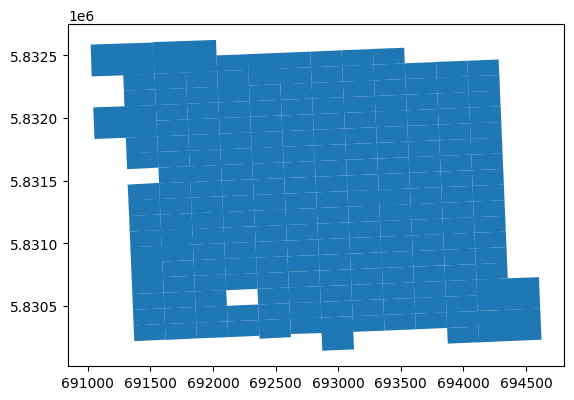

In [ ]:
lp.plot()

<Axes: >

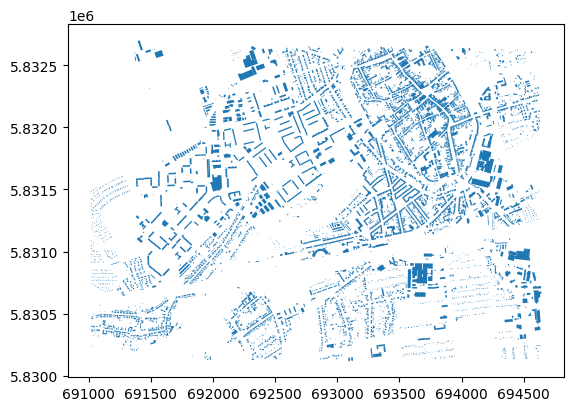

In [ ]:
haus.plot()

<Axes: >

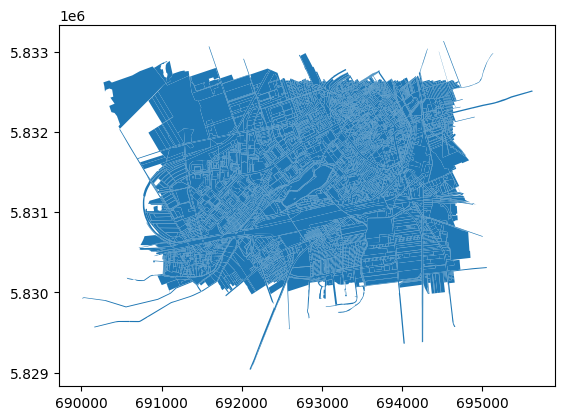

In [ ]:
flur.plot()

In [11]:
def get_affine_transformation(tfw_string):
    """Create affine transformation from TFW parameters in pipe-separated string format."""
    tfw_params = [float(x) for x in tfw_string.split('|')]
    xoffset, px_w, rot1, yoffset, rot2, px_h = tfw_params
    geotransform = (xoffset, px_w, rot1, yoffset, rot2, px_h)
    return Affine.from_gdal(*geotransform)

# Create a new column for affine transformation
stadt_df['affine_transform'] = None

# Apply transformation only to LAGEPLAENE rows
mask = stadt_df['layer'] == 'LAGEPLAENE'
stadt_df.loc[mask, 'affine_transform'] = stadt_df.loc[mask, 'TFW'].apply(get_affine_transformation)

# Verify
print("Number of affine transforms created:", stadt_df['affine_transform'].notna().sum())
print("\nExample of first LAGEPLAENE transform:")
print(stadt_df[stadt_df['layer'] == 'LAGEPLAENE']['affine_transform'].iloc[0])

Number of affine transforms created: 211

Example of first LAGEPLAENE transform:
| 0.03, 0.00, 691345.47|
| 0.00,-0.03, 5830844.14|
| 0.00, 0.00, 1.00|


In [ ]:
stadt_df

NAME                                                TFW   WIDTH  \
0      mgb1/8828ab  691345.4732|0.0317943251|0.001451167847|583084...  7871.0   
1      mgb1/8828ad  691351.1187|0.03179182459|0.001271360732|58307...  7865.0   
2      mgb1/8828ba  691595.848|0.03177956616|0.001306713676|583085...  7859.0   
3      mgb1/8828bb  691845.0007|0.03177973516|0.001466964258|58308...  7877.0   
4      mgb1/8828bc  691600.9705|0.03178174873|0.001322649449|58307...  7860.0   
...            ...                                                ...     ...   
18379          NaN                                                NaN     NaN   
18380          NaN                                                NaN     NaN   
18381          NaN                                                NaN     NaN   
18382          NaN                                                NaN     NaN   
18383          NaN                                                NaN     NaN   

       HEIGHT  DATABASE_ID                                           geometry  \
0      4295.0         60.0  POLYGON ((691345.473 5830844.137, 691595.726 5...   
1      3970.0         60.0  POLYGON ((691351.119 5830719.339, 691601.161 5...   
2      3965.0         60.0  POLYGON ((691595.848 5830854.41, 691845.604 58...   
3      4008.0         60.0  POLYGON ((691845.001 5830864.799, 692095.33 58...   
4      3975.0         60.0  POLYGON ((691600.971 5830729.514, 691850.775 5...   
...       ...          ...                                                ...   
18379     NaN          NaN  MULTIPOLYGON (((694285.227 5832413.659, 694282...   
18380     NaN          NaN  MULTIPOLYGON (((692851.063 5831839.722, 692831...   
18381     NaN          NaN  MULTIPOLYGON (((691988.866 5830816.087, 691995...   
18382     NaN          NaN  MULTIPOLYGON (((693000.708 5832463.496, 692991...   
18383     NaN          NaN  MULTIPOLYGON (((693679.046 5832190.213, 693691...   

            layer FUNKTION HU_ID  \
0      LAGEPLAENE      NaN   NaN   
1      LAGEPLAENE      NaN   NaN   
2      LAGEPLAENE      NaN   NaN   
3      LAGEPLAENE      NaN   NaN   
4      LAGEPLAENE      NaN   NaN   
...           ...      ...   ...   
18379  ALKIS_FLUR      NaN   NaN   
18380  ALKIS_FLUR      NaN   NaN   
18381  ALKIS_FLUR      NaN   NaN   
18382  ALKIS_FLUR      NaN   NaN   
18383  ALKIS_FLUR      NaN   NaN   

                                                Nutzung  \
0                                                   NaN   
1                                                   NaN   
2                                                   NaN   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
18379                                                     
18380                         Handel und Dienstleistung   
18381                                                     
18382                                                     
18383  Gebäude- und Freifläche, Mischnutzung mit Wohnen   

                          Objektart  \
0                               NaN   
1                               NaN   
2                               NaN   
3                               NaN   
4                               NaN   
...                             ...   
18379               Fliessgewaesser   
18380  Industrie Und Gewerbeflaeche   
18381                Wohnbauflaeche   
18382                Wohnbauflaeche   
18383    Flaeche Gemischter Nutzung   

                                        affine_transform  
0      (0.0317943251, 0.001451167847, 691345.4732, 0....  
1      (0.03179182459, 0.001271360732, 691351.1187, 0...  
2      (0.03177956616, 0.001306713676, 691595.848, 0....  
3      (0.03177973516, 0.001466964258, 691845.0007, 0...  
4      (0.03178174873, 0.001322649449, 691600.9705, 0...  
...                                                  ...  
18379                                       

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


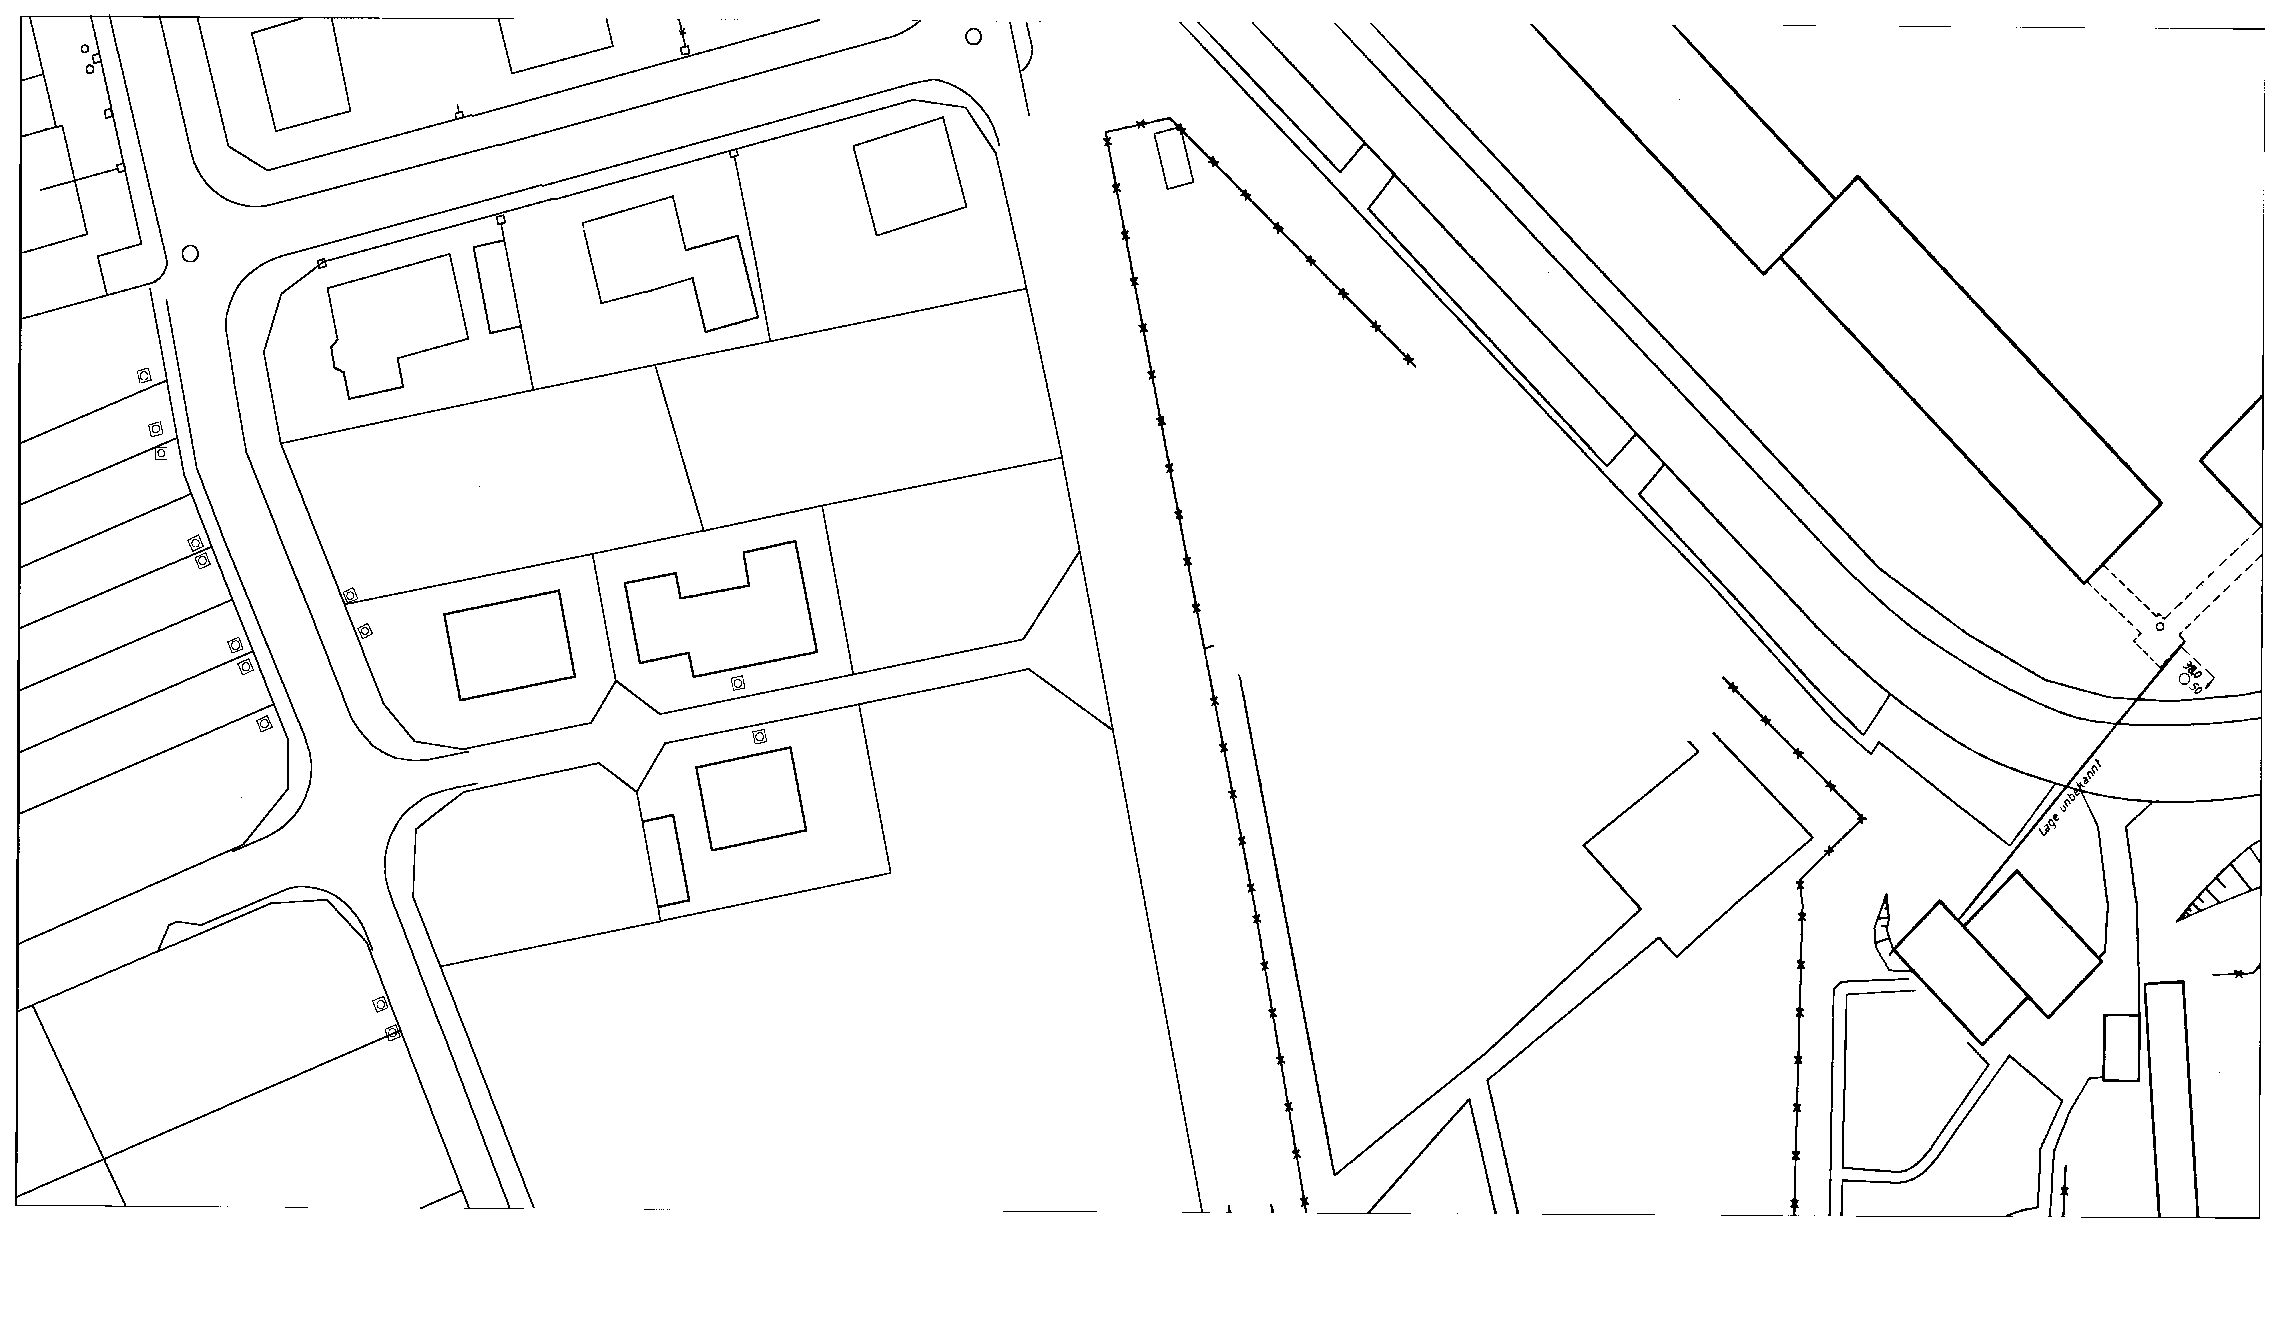

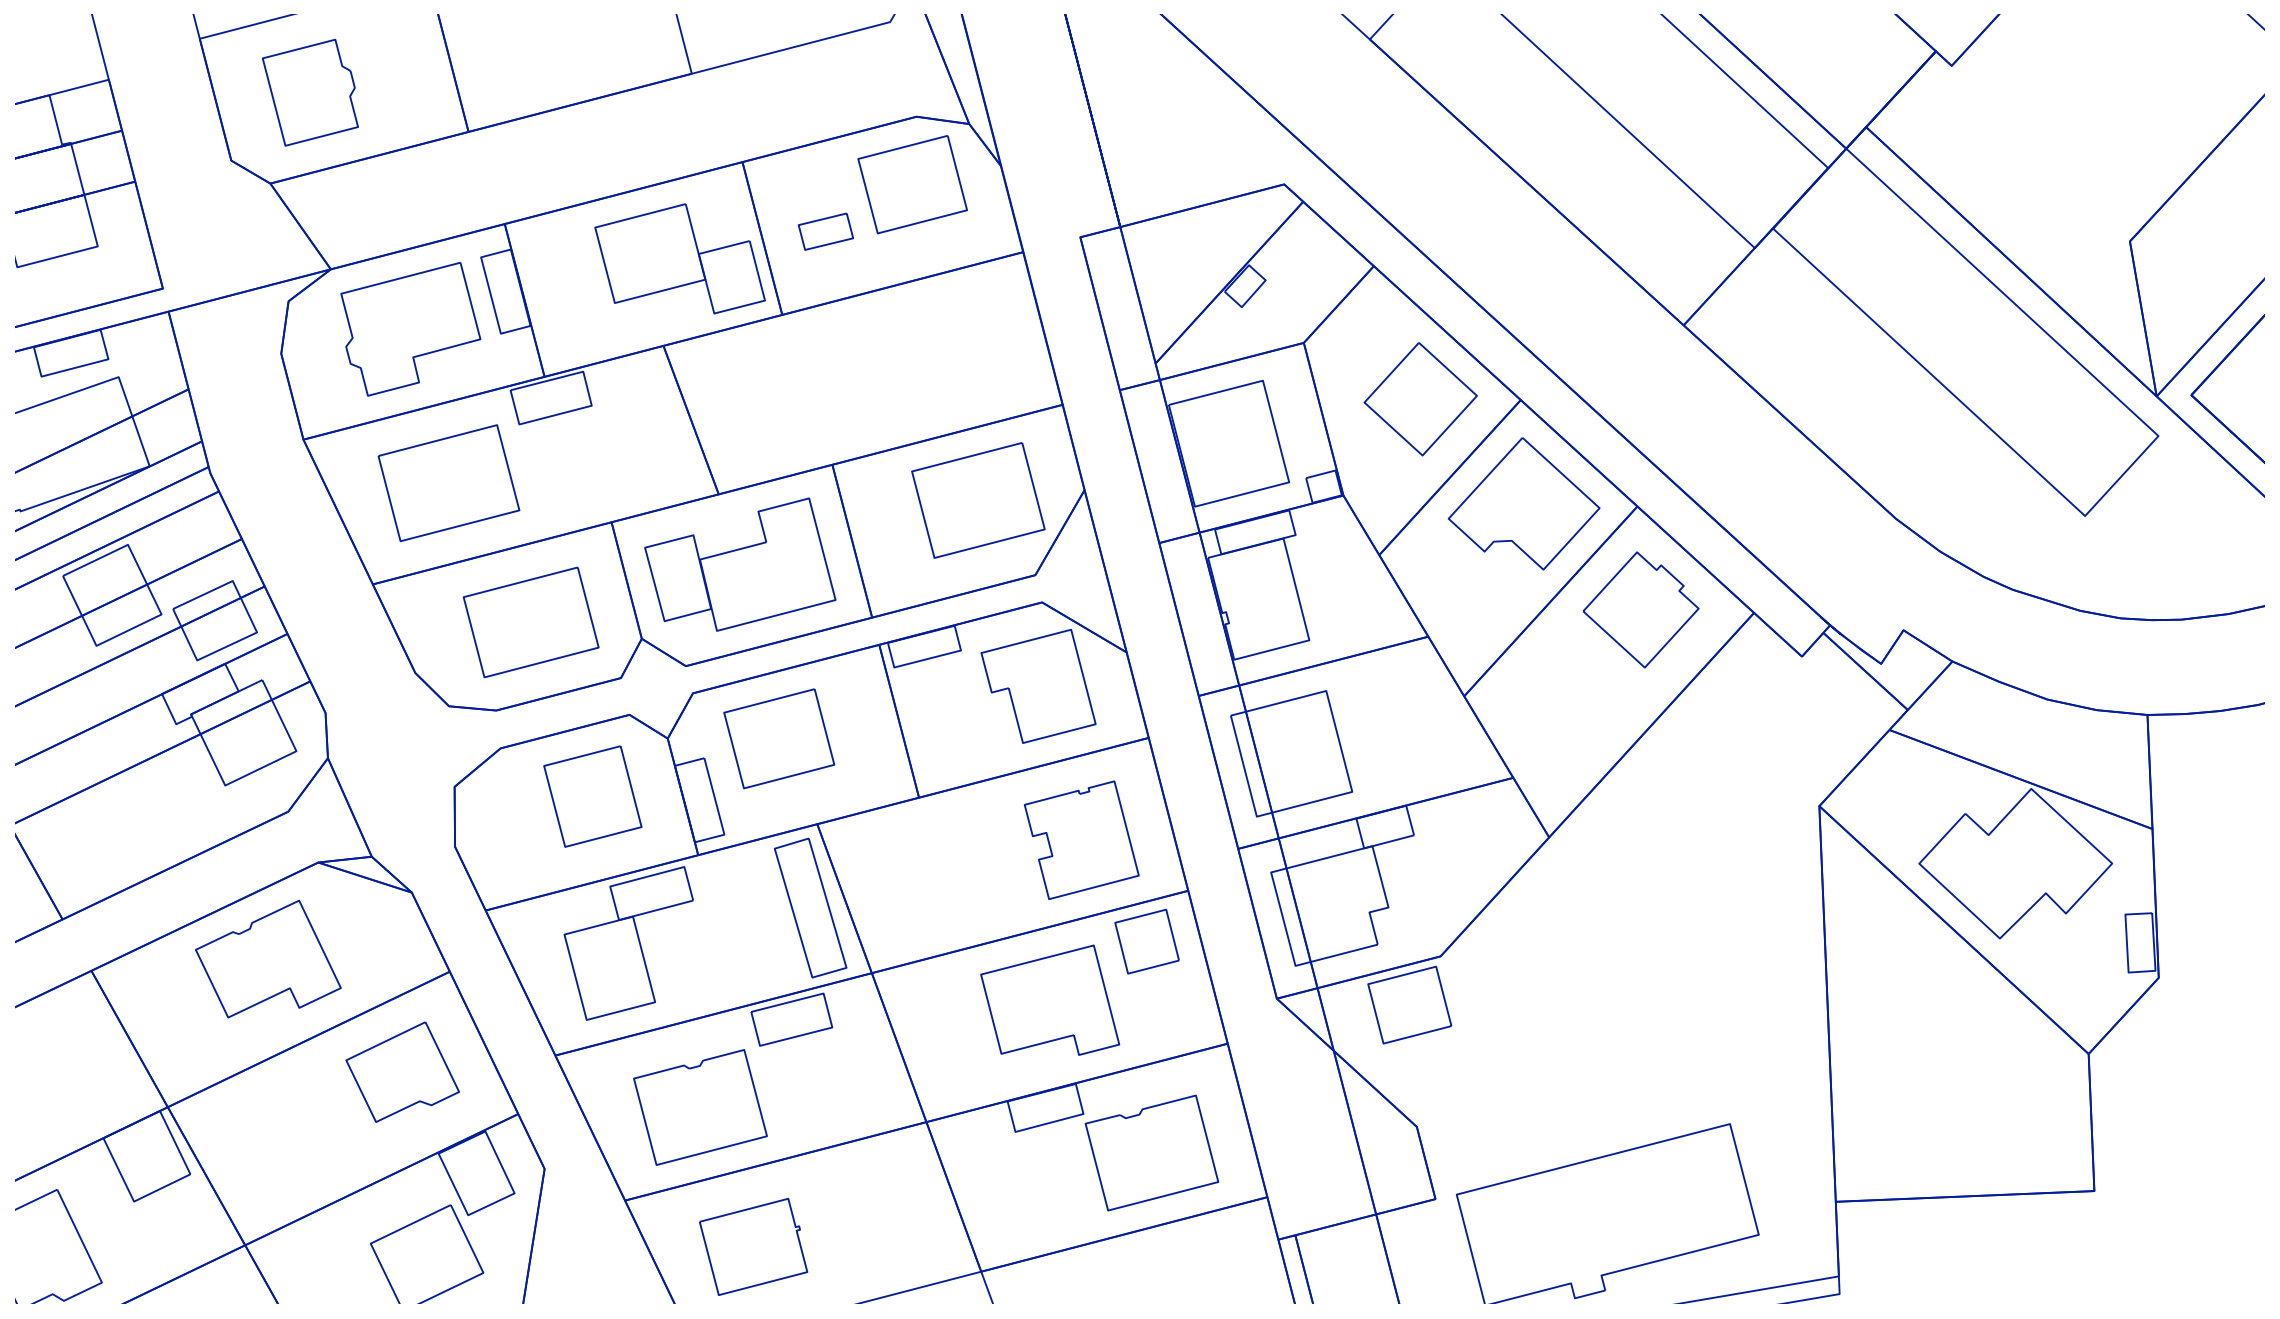

saved raster and alkis


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


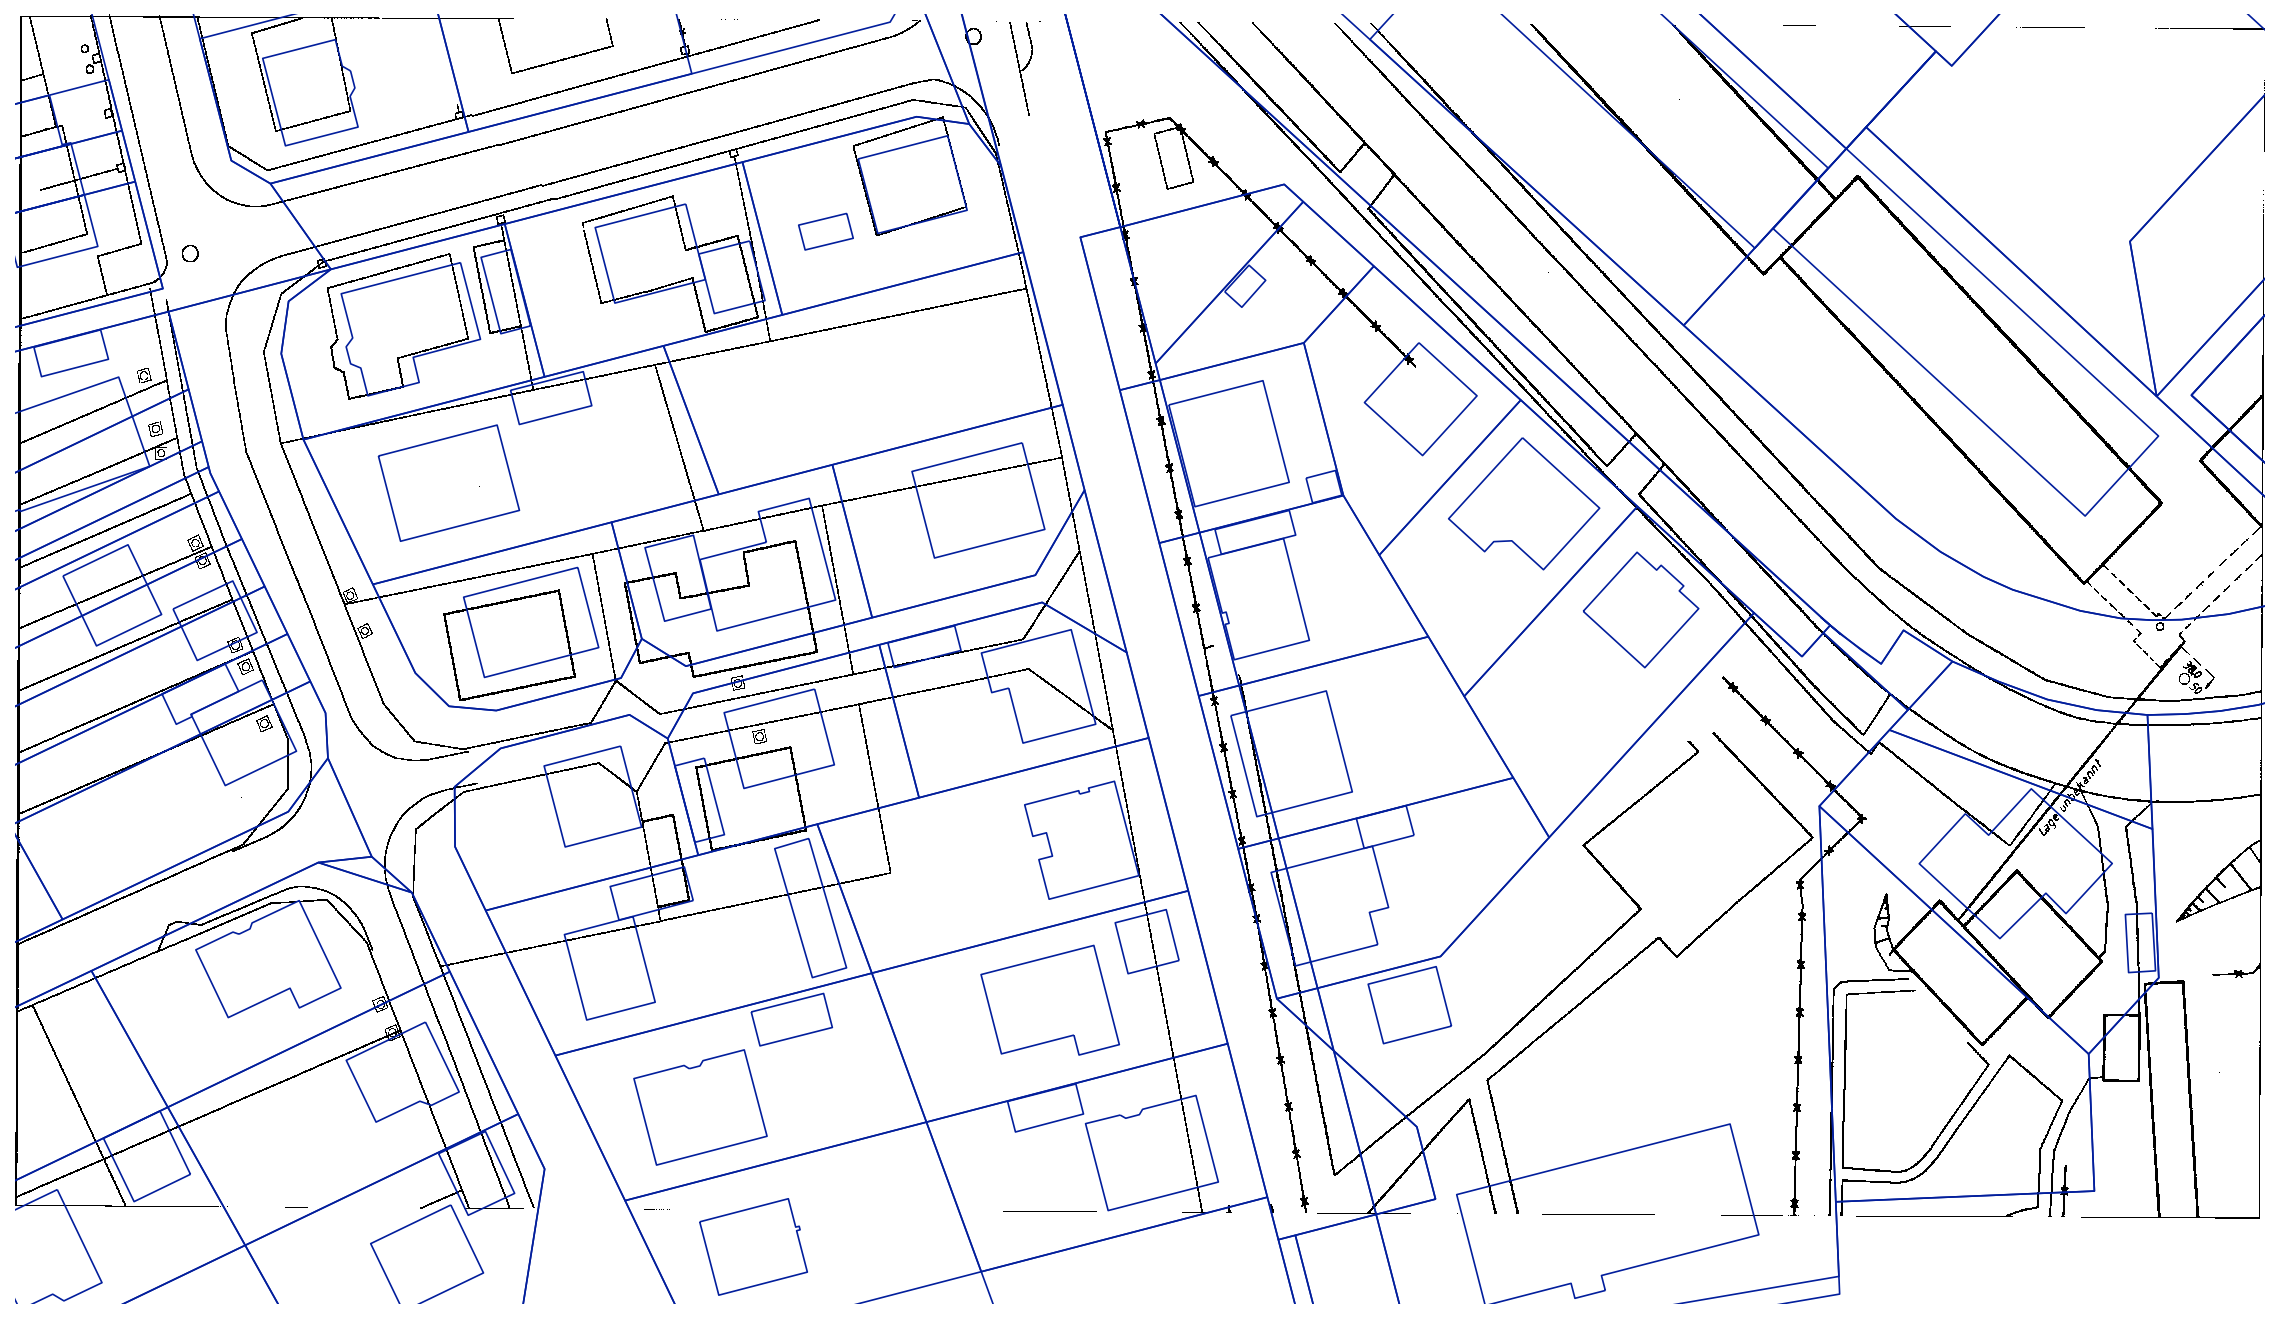

TIF file: 8828ab.tif
Number of intersecting features: 145


In [12]:
# Get LAGEPLAN info once
lageplan_row = stadt_df[stadt_df['layer'] == 'LAGEPLAENE'].iloc[0]
lageplan_polygon = lageplan_row.geometry
lageplan_name = lageplan_row['NAME']
tif_id = lageplan_name.split(prefix)[1]
bounds = lageplan_polygon.bounds

# Filter intersecting features once
intersecting_hu = stadt_df[
    (stadt_df['layer'].isin(['ALKIS_HU', 'ALKIS_FLUR'])) &
    (stadt_df.geometry.intersects(lageplan_polygon))
]

# Common plot settings
def setup_plot(fig, ax):
    ax.set_facecolor('white')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    plt.tight_layout(pad=0)

# 1. TIF only
fig1, ax1 = plt.subplots(figsize=(15, 10), facecolor='white', dpi=150)
with rasterio.open(BASE_PATH / "Raster" / f"{tif_id}.tif") as src:
    image = src.read(1)
    ax1.imshow(image,
              extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
              cmap='gray_r',
              interpolation='nearest')
setup_plot(fig1, ax1)
plt.savefig(BASE_PATH / "raster.png",
            bbox_inches='tight',
            pad_inches=0,
            dpi=150)
plt.show()

# 2. Vector data only
fig2, ax2 = plt.subplots(figsize=(15, 10), facecolor='white', dpi=150)
intersecting_hu.plot(ax=ax2,
                    facecolor='none',
                    edgecolor='#021e9c',
                    linewidth=0.9)
setup_plot(fig2, ax2)
plt.savefig(BASE_PATH / "alkis.png",
            bbox_inches='tight',
            pad_inches=0,
            dpi=150)
plt.show()
print("saved raster and alkis")
# 3. Combined overlay
fig3, ax3 = plt.subplots(figsize=(15, 10), facecolor='white', dpi=150)
with rasterio.open(BASE_PATH / "Raster" / f"{tif_id}.tif") as src:
    image = src.read(1)
    ax3.imshow(image,
              extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
              cmap='gray_r',
              interpolation='nearest')
intersecting_hu.plot(ax=ax3,
                    facecolor='none',
                    edgecolor='#021e9c',
                    linewidth=0.8)
setup_plot(fig3, ax3)
plt.show()

print(f"TIF file: {tif_id}.tif")
print(f"Number of intersecting features: {len(intersecting_hu)}")

## match images
left alkis right raster

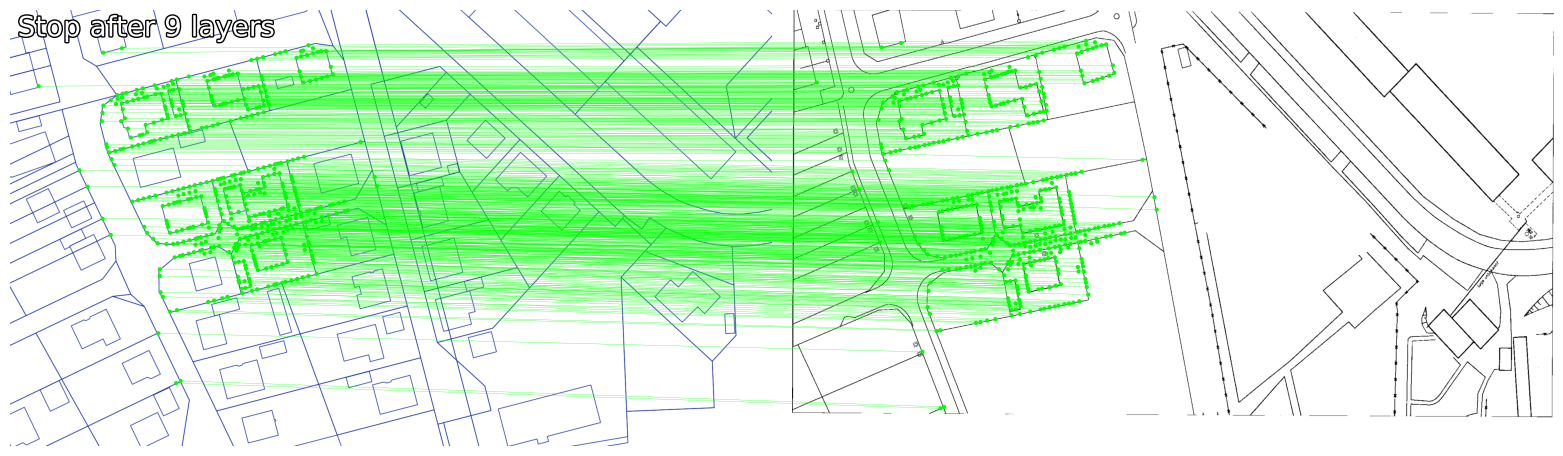

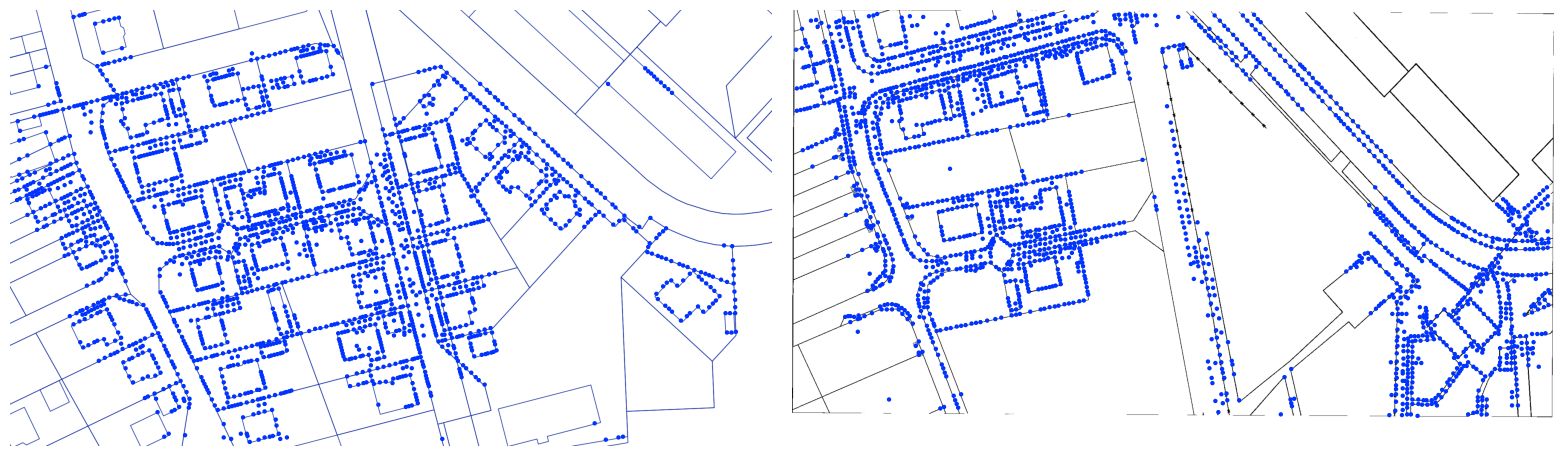

In [46]:
image0 = load_image(BASE_PATH / "alkis.png")
image1 = load_image(BASE_PATH / "raster.png")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

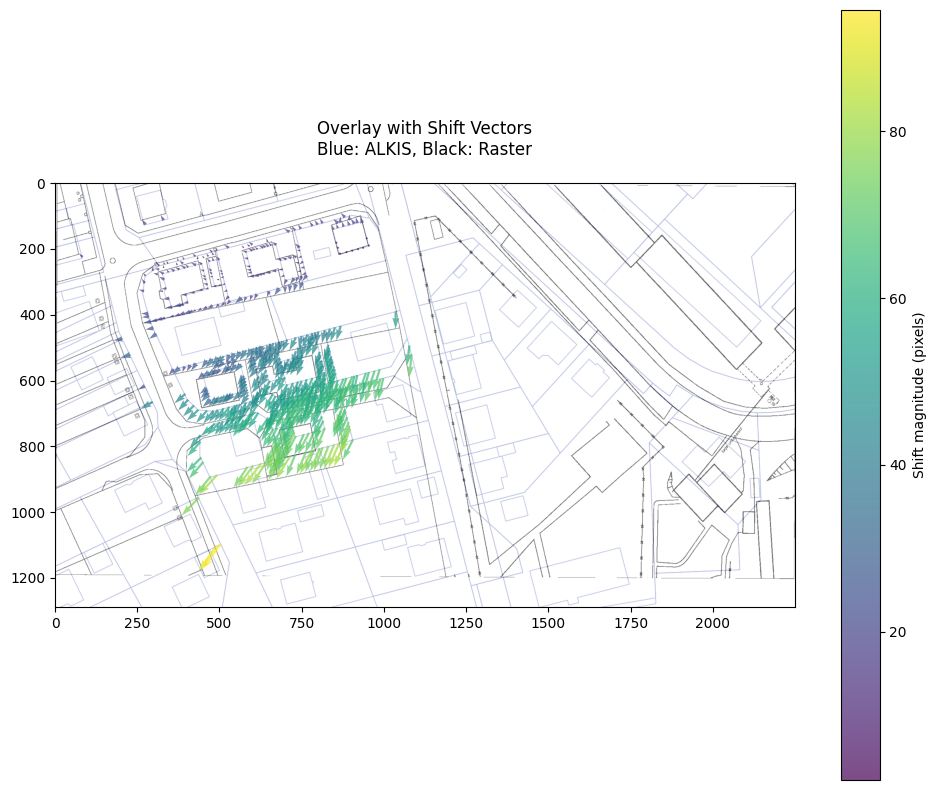


Shift statistics:
Number of matches: 483
Average shift magnitude: 40.5 pixels
Max shift magnitude: 94.6 pixels
Min shift magnitude: 2.2 pixels


In [47]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Create visualization with just the overlay plot
plt.figure(figsize=(10, 8))

# Convert images and keypoints to numpy
image0_np = image0.cpu().numpy().transpose(1, 2, 0)
image1_np = image1.cpu().numpy().transpose(1, 2, 0)
m_kpts0_np = m_kpts0.cpu().numpy()
m_kpts1_np = m_kpts1.cpu().numpy()

# Calculate shifts
shifts = m_kpts1_np - m_kpts0_np
magnitudes = np.sqrt(np.sum(shifts**2, axis=1))

# Show overlaid images with adjusted alpha values and colors
plt.imshow(image0_np, cmap='Reds', alpha=0.8)  # Increased alpha for vector data
plt.imshow(image1_np, cmap='Blues', alpha=0.6)  # Reduced alpha for raster data

# Draw shift vectors with arrows
plt.quiver(m_kpts0_np[:, 0], m_kpts0_np[:, 1],
          shifts[:, 0], shifts[:, 1],
          magnitudes,
          cmap='viridis',
          angles='xy',
          scale_units='xy',
          scale=1,
          width=0.003,
          headwidth=3,
          headlength=5,
          headaxislength=4.5,
          alpha=0.7)  # Increased arrow visibility

plt.colorbar(label='Shift magnitude (pixels)')
plt.title('Overlay with Shift Vectors\nBlue: ALKIS, Black: Raster', pad=20)

# Optional: Adjust figure background to make lines more visible
plt.gca().set_facecolor('white')  # White background
plt.grid(False)  # Remove grid if present

plt.tight_layout()
plt.show()

# Print shift statistics
print("\nShift statistics:")
print(f"Number of matches: {len(matches)}")
print(f"Average shift magnitude: {np.mean(magnitudes):.1f} pixels")
print(f"Max shift magnitude: {np.max(magnitudes):.1f} pixels")
print(f"Min shift magnitude: {np.min(magnitudes):.1f} pixels")

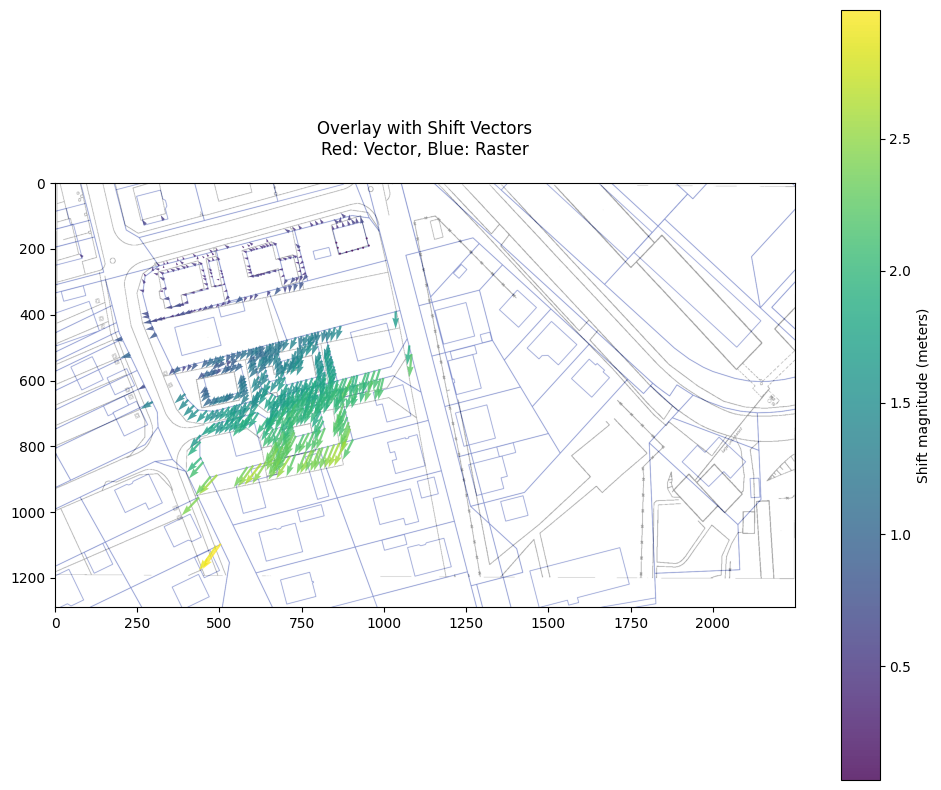


Shift statistics:
Number of matches: 483

In pixels:
Average shift magnitude: 40.5 pixels
Max shift magnitude: 94.6 pixels
Min shift magnitude: 2.2 pixels

In world coordinates (meters):
Average shift magnitude: 1.28 m
Max shift magnitude: 2.99 m
Min shift magnitude: 0.07 m

Shift directions:
Average angle: -76.6 degrees
Angle standard deviation: 102.4 degrees


In [48]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from affine import Affine

def pixel_to_world_shifts(shifts_px, affine_transform):
    """
    Convert pixel shifts to world coordinates using affine transformation
    """
    # Scale shifts by pixel size
    world_shifts = np.zeros_like(shifts_px)
    world_shifts[:, 0] = shifts_px[:, 0] * affine_transform.a  # x shifts
    world_shifts[:, 1] = shifts_px[:, 1] * affine_transform.e  # y shifts
    return world_shifts

# Create visualization with just the overlay plot
plt.figure(figsize=(10, 8))

# Convert images and keypoints to numpy
image0_np = image0.cpu().numpy().transpose(1, 2, 0)
image1_np = image1.cpu().numpy().transpose(1, 2, 0)
m_kpts0_np = m_kpts0.cpu().numpy()
m_kpts1_np = m_kpts1.cpu().numpy()

# Calculate shifts in pixels
shifts_px = m_kpts1_np - m_kpts0_np
magnitudes_px = np.sqrt(np.sum(shifts_px**2, axis=1))

# Convert to world coordinates using the affine transform
affine_transform = stadt_df[stadt_df['layer'] == 'LAGEPLAENE']['affine_transform'].iloc[0]
world_shifts = pixel_to_world_shifts(shifts_px, affine_transform)
world_magnitudes = np.sqrt(np.sum(world_shifts**2, axis=1))

# Show overlaid images
plt.imshow(image0_np, cmap='Reds', alpha=0.9)
plt.imshow(image1_np, cmap='Blues', alpha=0.4)

# Draw shift vectors with arrows (still using pixel coordinates for position)
plt.quiver(m_kpts0_np[:, 0], m_kpts0_np[:, 1],
          shifts_px[:, 0], shifts_px[:, 1],
          world_magnitudes,  # color by world magnitude
          cmap='viridis',
          angles='xy',
          scale_units='xy',
          scale=1,
          width=0.003,
          headwidth=3,
          headlength=5,
          headaxislength=4.5,
          alpha=0.8)

plt.colorbar(label='Shift magnitude (meters)')
plt.title('Overlay with Shift Vectors\nRed: Vector, Blue: Raster', pad=20)
plt.gca().set_facecolor('white')
plt.grid(False)

plt.tight_layout()
plt.show()

# Print statistics in both pixel and world coordinates
print("\nShift statistics:")
print(f"Number of matches: {len(shifts_px)}")
print("\nIn pixels:")
print(f"Average shift magnitude: {np.mean(magnitudes_px):.1f} pixels")
print(f"Max shift magnitude: {np.max(magnitudes_px):.1f} pixels")
print(f"Min shift magnitude: {np.min(magnitudes_px):.1f} pixels")

print("\nIn world coordinates (meters):")
print(f"Average shift magnitude: {np.mean(world_magnitudes):.2f} m")
print(f"Max shift magnitude: {np.max(world_magnitudes):.2f} m")
print(f"Min shift magnitude: {np.min(world_magnitudes):.2f} m")

# Optional: Show shift direction statistics
angles = np.degrees(np.arctan2(world_shifts[:, 1], world_shifts[:, 0]))
print("\nShift directions:")
print(f"Average angle: {np.mean(angles):.1f} degrees")
print(f"Angle standard deviation: {np.std(angles):.1f} degrees")

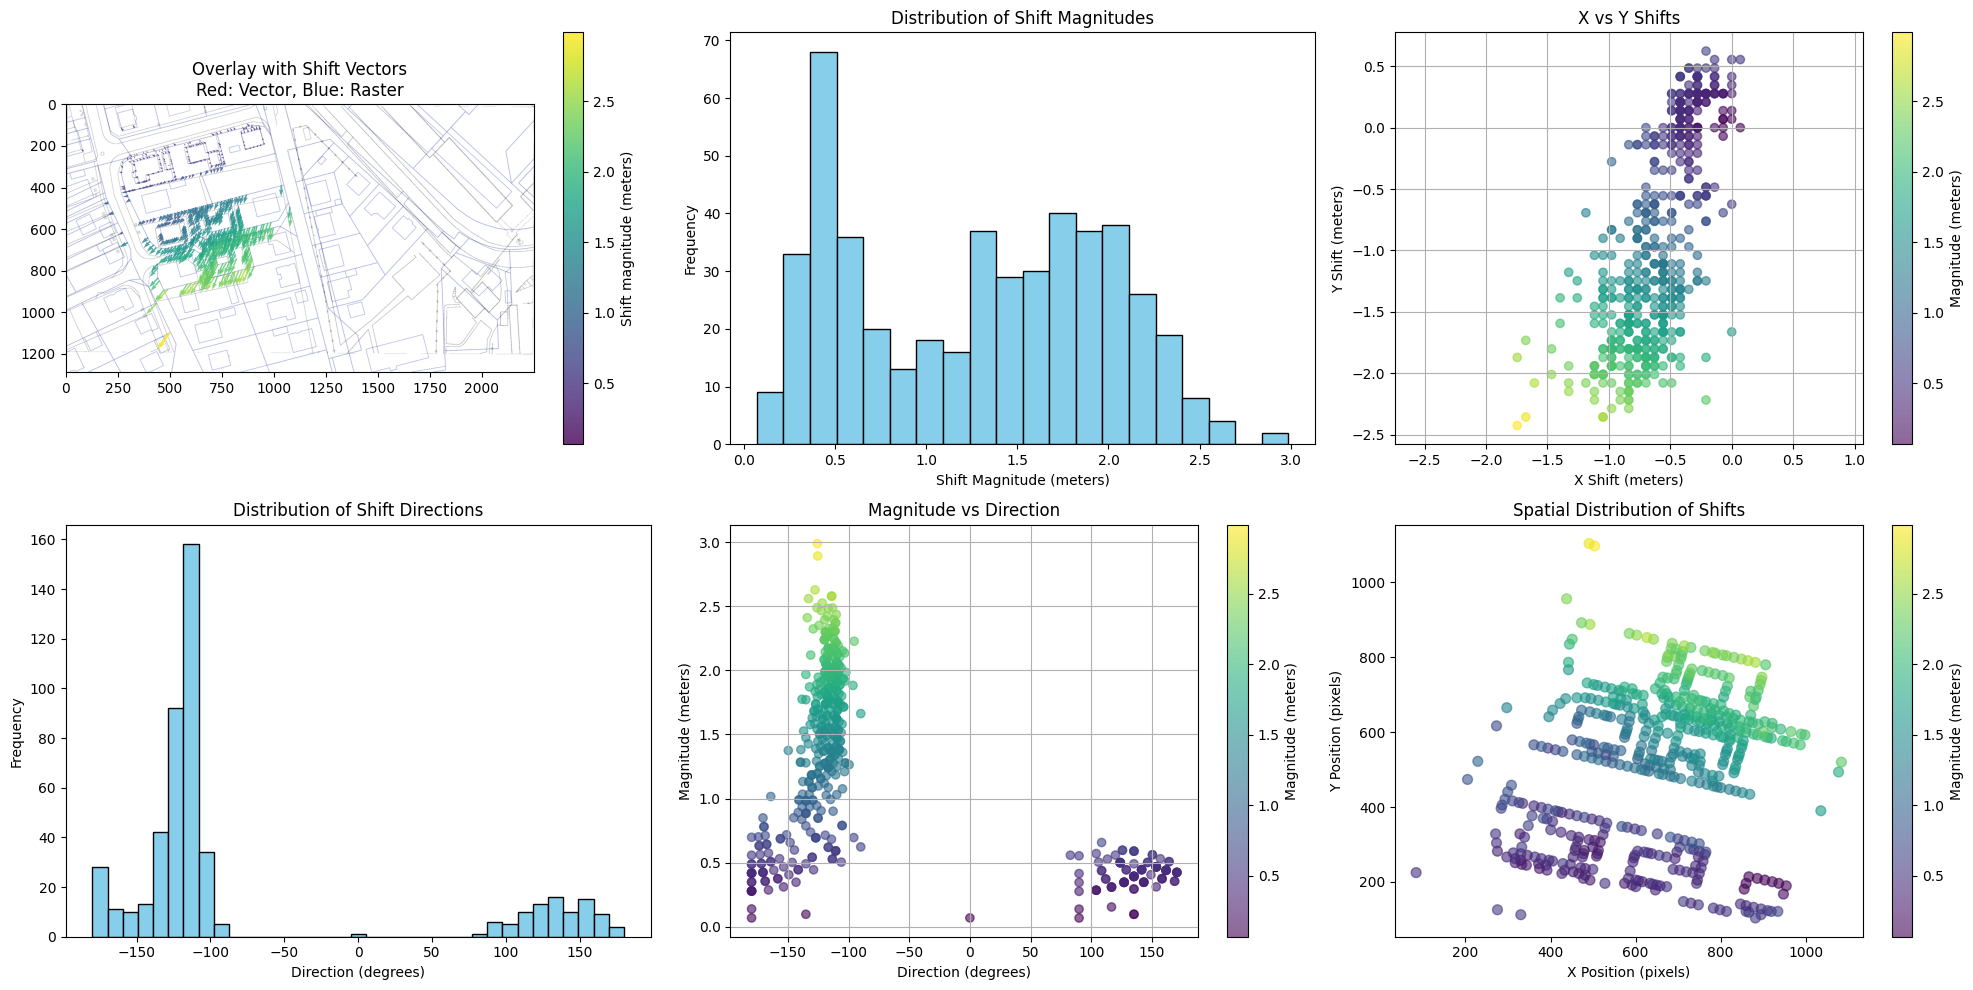


Shift Statistics Summary:
-----------------------
Number of matches: 483

Magnitudes (meters):
Mean: 1.279
Median: 1.367
Std Dev: 0.693
Min: 0.069
Max: 2.988

Directions (degrees):
Mean: -76.6
Median: -115.4
Std Dev: 102.4
Dominant direction: -121.6 degrees


In [49]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from affine import Affine

def pixel_to_world_shifts(shifts_px, affine_transform):
    """
    Convert pixel shifts to world coordinates using affine transformation
    """
    world_shifts = np.zeros_like(shifts_px)
    world_shifts[:, 0] = shifts_px[:, 0] * affine_transform.a  # x shifts
    world_shifts[:, 1] = shifts_px[:, 1] * affine_transform.e  # y shifts
    return world_shifts

# Create figure with multiple subplots
plt.figure(figsize=(20, 10))

# Convert images and keypoints to numpy
image0_np = image0.cpu().numpy().transpose(1, 2, 0)
image1_np = image1.cpu().numpy().transpose(1, 2, 0)
m_kpts0_np = m_kpts0.cpu().numpy()
m_kpts1_np = m_kpts1.cpu().numpy()

# Calculate shifts in pixels and world coordinates
shifts_px = m_kpts1_np - m_kpts0_np
magnitudes_px = np.sqrt(np.sum(shifts_px**2, axis=1))

affine_transform = stadt_df[stadt_df['layer'] == 'LAGEPLAENE']['affine_transform'].iloc[0]
world_shifts = pixel_to_world_shifts(shifts_px, affine_transform)
world_magnitudes = np.sqrt(np.sum(world_shifts**2, axis=1))

# 1. Main overlay with shift vectors
plt.subplot(231)
plt.imshow(image0_np, cmap='Reds', alpha=0.9)
plt.imshow(image1_np, cmap='Blues', alpha=0.4)

plt.quiver(m_kpts0_np[:, 0], m_kpts0_np[:, 1],
          shifts_px[:, 0], shifts_px[:, 1],
          world_magnitudes,
          cmap='viridis',
          angles='xy',
          scale_units='xy',
          scale=1,
          width=0.003,
          headwidth=3,
          headlength=5,
          headaxislength=4.5,
          alpha=0.8)

plt.colorbar(label='Shift magnitude (meters)')
plt.title('Overlay with Shift Vectors\nRed: Vector, Blue: Raster')

# 2. Histogram of shift magnitudes
plt.subplot(232)
plt.hist(world_magnitudes, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Shift Magnitude (meters)')
plt.ylabel('Frequency')
plt.title('Distribution of Shift Magnitudes')

# 3. Scatter plot of X vs Y shifts
plt.subplot(233)
plt.scatter(world_shifts[:, 0], world_shifts[:, 1],
           c=world_magnitudes, cmap='viridis', alpha=0.6)
plt.colorbar(label='Magnitude (meters)')
plt.xlabel('X Shift (meters)')
plt.ylabel('Y Shift (meters)')
plt.title('X vs Y Shifts')
plt.axis('equal')
plt.grid(True)

# 4. Rose diagram of shift directions
plt.subplot(234)
angles = np.degrees(np.arctan2(world_shifts[:, 1], world_shifts[:, 0]))
bins = np.linspace(-180, 180, 36)
plt.hist(angles, bins=bins, color='skyblue', edgecolor='black')
plt.xlabel('Direction (degrees)')
plt.ylabel('Frequency')
plt.title('Distribution of Shift Directions')

# 5. Magnitude vs Direction scatter
plt.subplot(235)
plt.scatter(angles, world_magnitudes, c=world_magnitudes,
           cmap='viridis', alpha=0.6)
plt.colorbar(label='Magnitude (meters)')
plt.xlabel('Direction (degrees)')
plt.ylabel('Magnitude (meters)')
plt.title('Magnitude vs Direction')
plt.grid(True)

# 6. Spatial distribution of magnitudes
plt.subplot(236)
plt.scatter(m_kpts0_np[:, 0], m_kpts0_np[:, 1],
           c=world_magnitudes, cmap='viridis', s=50, alpha=0.6)
plt.colorbar(label='Magnitude (meters)')
plt.xlabel('X Position (pixels)')
plt.ylabel('Y Position (pixels)')
plt.title('Spatial Distribution of Shifts')

plt.tight_layout()
plt.show()

# Print comprehensive statistics
print("\nShift Statistics Summary:")
print("-----------------------")
print(f"Number of matches: {len(shifts_px)}")
print("\nMagnitudes (meters):")
print(f"Mean: {np.mean(world_magnitudes):.3f}")
print(f"Median: {np.median(world_magnitudes):.3f}")
print(f"Std Dev: {np.std(world_magnitudes):.3f}")
print(f"Min: {np.min(world_magnitudes):.3f}")
print(f"Max: {np.max(world_magnitudes):.3f}")

print("\nDirections (degrees):")
print(f"Mean: {np.mean(angles):.1f}")
print(f"Median: {np.median(angles):.1f}")
print(f"Std Dev: {np.std(angles):.1f}")

# Calculate and print dominant direction
hist, bins = np.histogram(angles, bins=36)
dominant_direction = bins[np.argmax(hist)]
print(f"Dominant direction: {dominant_direction:.1f} degrees")

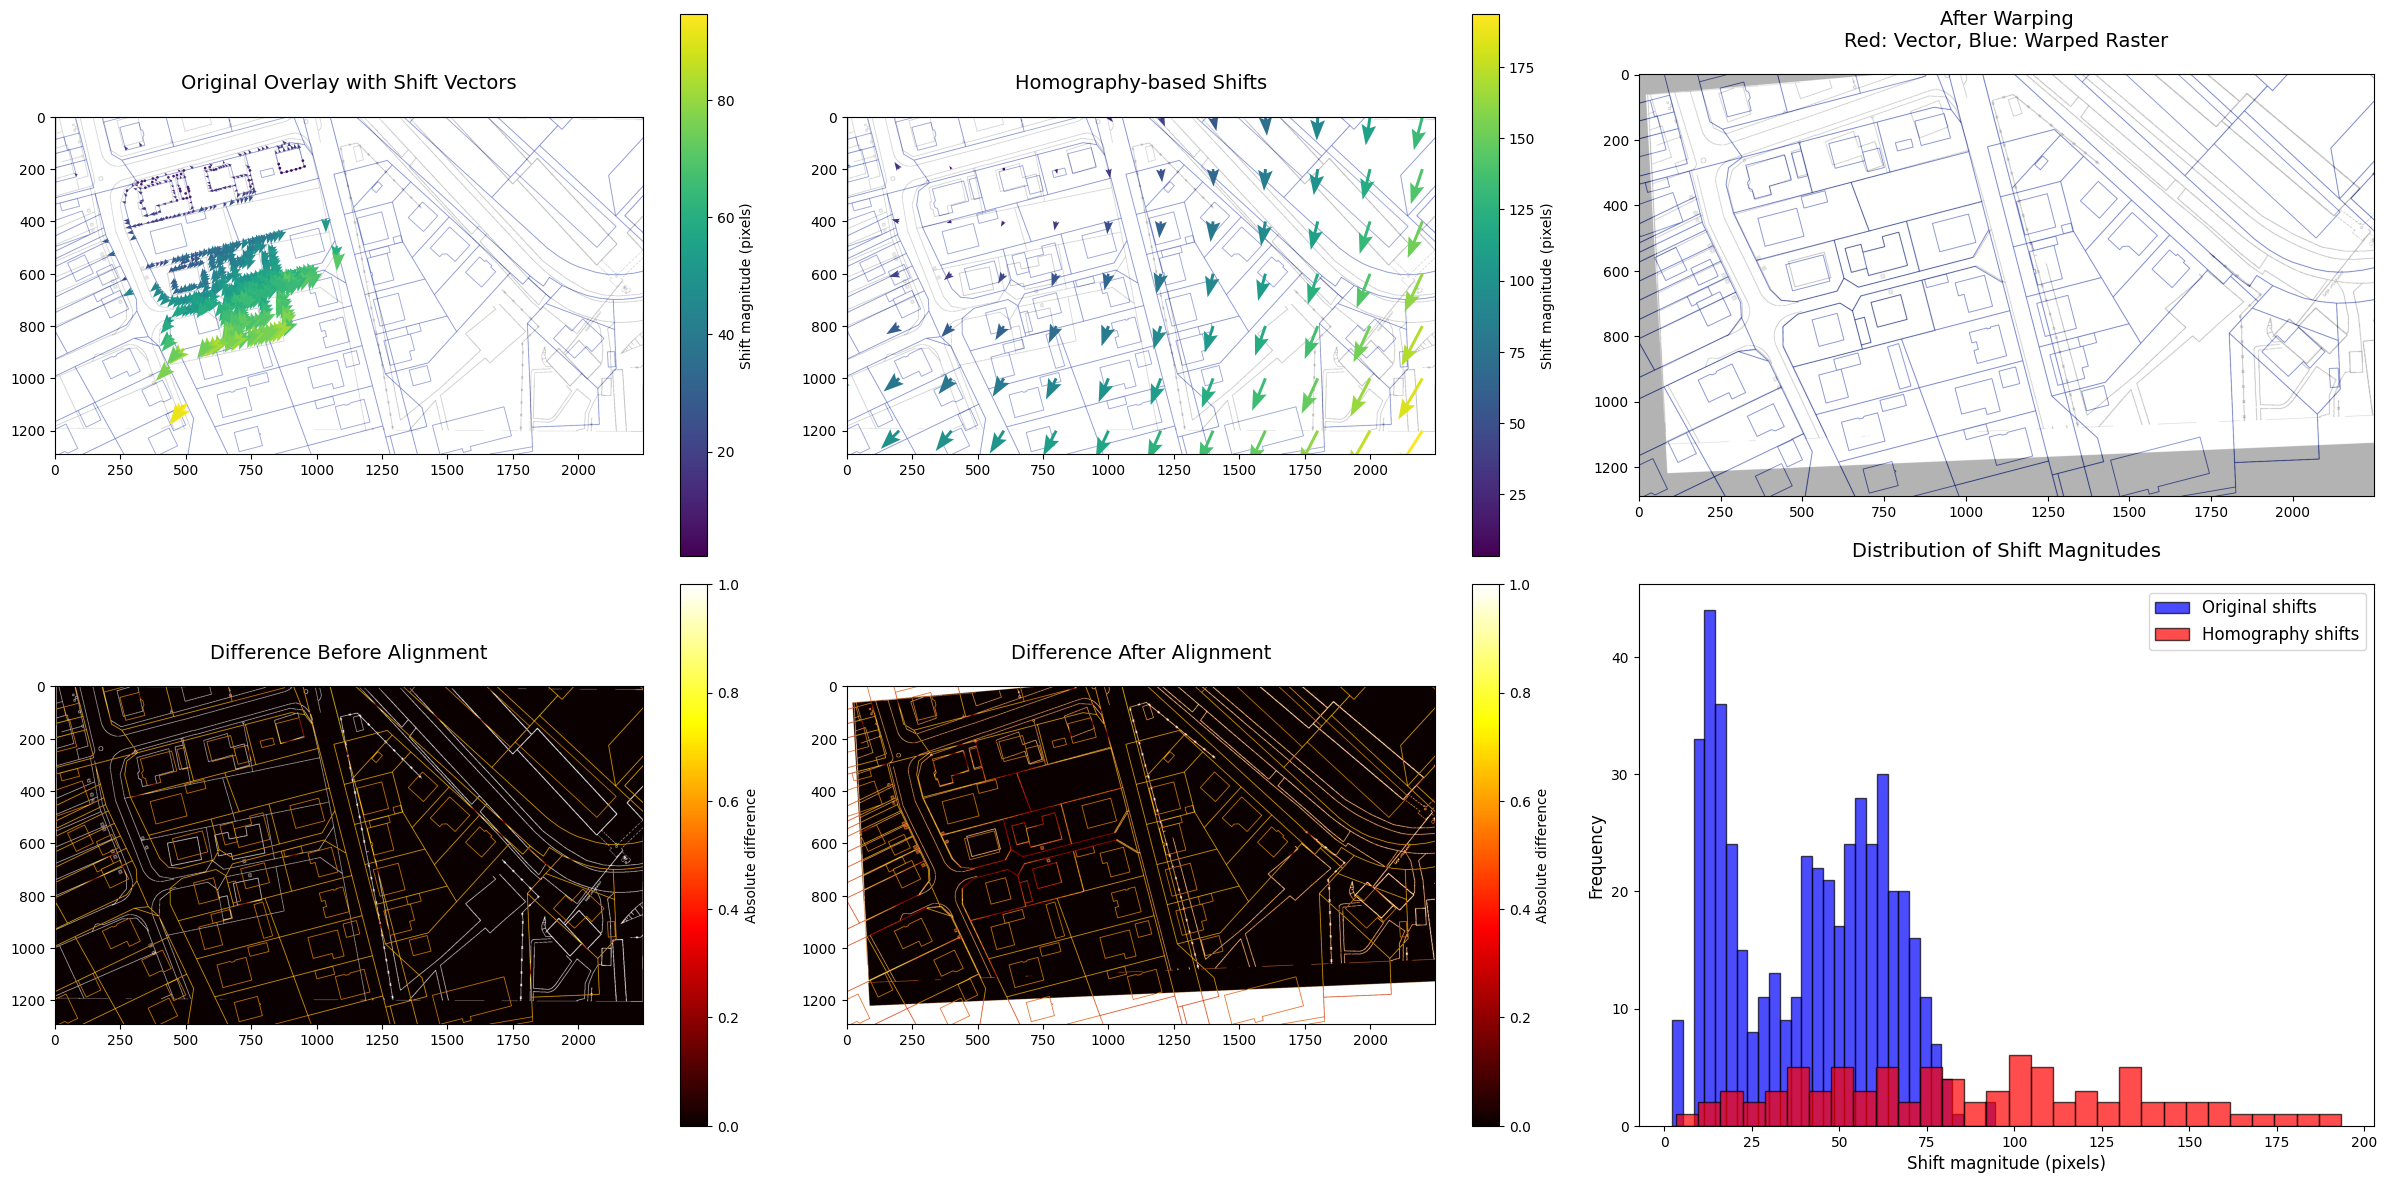


Original shift statistics:
Average magnitude: 40.5 pixels
Max magnitude: 94.6 pixels
Min magnitude: 2.2 pixels

Homography shift statistics:
Average magnitude: 87.8 pixels
Max magnitude: 193.3 pixels
Min magnitude: 3.4 pixels

RANSAC inliers: 48.4%


In [51]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2

def get_shifts_from_homography(H, image_shape, grid_spacing=50):
    """
    Extract shift vectors from homography matrix
    """
    height, width = image_shape[:2]

    # Create grid of points
    y, x = np.mgrid[0:height:grid_spacing, 0:width:grid_spacing]
    points = np.stack([x.ravel(), y.ravel()], axis=1)

    # Add homogeneous coordinate
    homogeneous_points = np.column_stack([points, np.ones(len(points))])

    # Transform points using homography
    transformed_points = H @ homogeneous_points.T
    transformed_points = transformed_points / transformed_points[2]  # Normalize homogeneous coordinates
    transformed_points = transformed_points[:2].T

    # Calculate shifts
    shifts = transformed_points - points

    return points, shifts

def create_visible_overlay(img1, img2):
    """
    Create a more visible overlay of two images
    img1 will be shown in red, img2 in blue
    """
    # Create RGB image
    overlay = np.zeros((*img1.shape[:2], 3))

    # Convert to float and normalize if needed
    img1_norm = img1.astype(float) / 255 if img1.max() > 1 else img1.astype(float)
    img2_norm = img2.astype(float) / 255 if img2.max() > 1 else img2.astype(float)

    # Assign channels
    overlay[..., 0] = img1_norm  # Red channel for img1
    overlay[..., 2] = img2_norm  # Blue channel for img2

    return overlay

# Convert keypoints to numpy format for OpenCV
m_kpts0_np = m_kpts0.cpu().numpy()
m_kpts1_np = m_kpts1.cpu().numpy()

# Calculate homography matrix
H, mask = cv2.findHomography(m_kpts1_np, m_kpts0_np, cv2.RANSAC, 5.0)

# Create visua# Create visualization with larger figure size and adjusted parameters
plt.figure(figsize=(24, 12))

# Convert images and calculate homography
image0_np = image0.cpu().numpy().transpose(1, 2, 0)
image1_np = image1.cpu().numpy().transpose(1, 2, 0)
m_kpts0_np = m_kpts0.cpu().numpy()
m_kpts1_np = m_kpts1.cpu().numpy()
H, mask = cv2.findHomography(m_kpts1_np, m_kpts0_np, cv2.RANSAC, 5.0)

# 1. Original overlay with shift vectors
plt.subplot(231)
plt.imshow(image0_np, cmap='Reds', alpha=1.0)  # Increased alpha for vector
plt.imshow(image1_np, cmap='Blues', alpha=0.3)  # Reduced alpha for raster

shifts = m_kpts1_np - m_kpts0_np
magnitudes = np.sqrt(np.sum(shifts**2, axis=1))

plt.quiver(m_kpts0_np[:, 0], m_kpts0_np[:, 1],
          shifts[:, 0], shifts[:, 1],
          magnitudes,
          cmap='viridis',
          angles='xy',
          scale_units='xy',
          scale=1,
          width=0.005,  # Thicker arrows
          headwidth=5,  # Larger arrow heads
          headlength=7,
          headaxislength=6,
          alpha=1.0)  # Full opacity for arrows

plt.colorbar(label='Shift magnitude (pixels)')
plt.title('Original Overlay with Shift Vectors', fontsize=14, pad=20)

# 2. Grid of shifts from homography
plt.subplot(232)
points, h_shifts = get_shifts_from_homography(H, image1_np.shape, grid_spacing=200)  # Adjusted grid spacing
h_magnitudes = np.sqrt(np.sum(h_shifts**2, axis=1))

plt.imshow(image0_np, cmap='Reds', alpha=1.0)
plt.imshow(image1_np, cmap='Blues', alpha=0.3)
# For the homography shifts plot, reverse the direction:
plt.quiver(points[:, 0], points[:, 1],
          -h_shifts[:, 0], -h_shifts[:, 1],  # Note the negative signs
          h_magnitudes,
          cmap='viridis',
          angles='xy',
          scale_units='xy',
          scale=1,
          width=0.005,
          headwidth=5,
          headlength=7,
          headaxislength=6,
          alpha=1.0)
plt.colorbar(label='Shift magnitude (pixels)')
plt.title('Homography-based Shifts', fontsize=14, pad=20)

# 3. After warping
plt.subplot(233)
warped_image = cv2.warpPerspective(image1_np, H,
                                 (image0_np.shape[1], image0_np.shape[0]))
plt.imshow(image0_np, cmap='Reds', alpha=1.0)
plt.imshow(warped_image, cmap='Blues', alpha=0.3)
plt.title('After Warping\nRed: Vector, Blue: Warped Raster', fontsize=14, pad=20)

# 4. Difference before
plt.subplot(234)
diff_before = np.abs(image0_np - image1_np).mean(axis=2)
plt.imshow(diff_before, cmap='hot')
plt.colorbar(label='Absolute difference')
plt.title('Difference Before Alignment', fontsize=14, pad=20)

# 5. Difference after
plt.subplot(235)
diff_after = np.abs(image0_np - warped_image).mean(axis=2)
plt.imshow(diff_after, cmap='hot')
plt.colorbar(label='Absolute difference')
plt.title('Difference After Alignment', fontsize=14, pad=20)

# 6. Shift statistics
plt.subplot(236)
plt.hist(magnitudes, bins=30, alpha=0.7, label='Original shifts', color='blue', edgecolor='black')
plt.hist(h_magnitudes, bins=30, alpha=0.7, label='Homography shifts', color='red', edgecolor='black')
plt.xlabel('Shift magnitude (pixels)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=12)
plt.title('Distribution of Shift Magnitudes', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

# Print statistics
print("\nOriginal shift statistics:")
print(f"Average magnitude: {np.mean(magnitudes):.1f} pixels")
print(f"Max magnitude: {np.max(magnitudes):.1f} pixels")
print(f"Min magnitude: {np.min(magnitudes):.1f} pixels")

print("\nHomography shift statistics:")
print(f"Average magnitude: {np.mean(h_magnitudes):.1f} pixels")
print(f"Max magnitude: {np.max(h_magnitudes):.1f} pixels")
print(f"Min magnitude: {np.min(h_magnitudes):.1f} pixels")

print("\nRANSAC inliers: {:.1f}%".format(mask.sum() / len(mask) * 100))

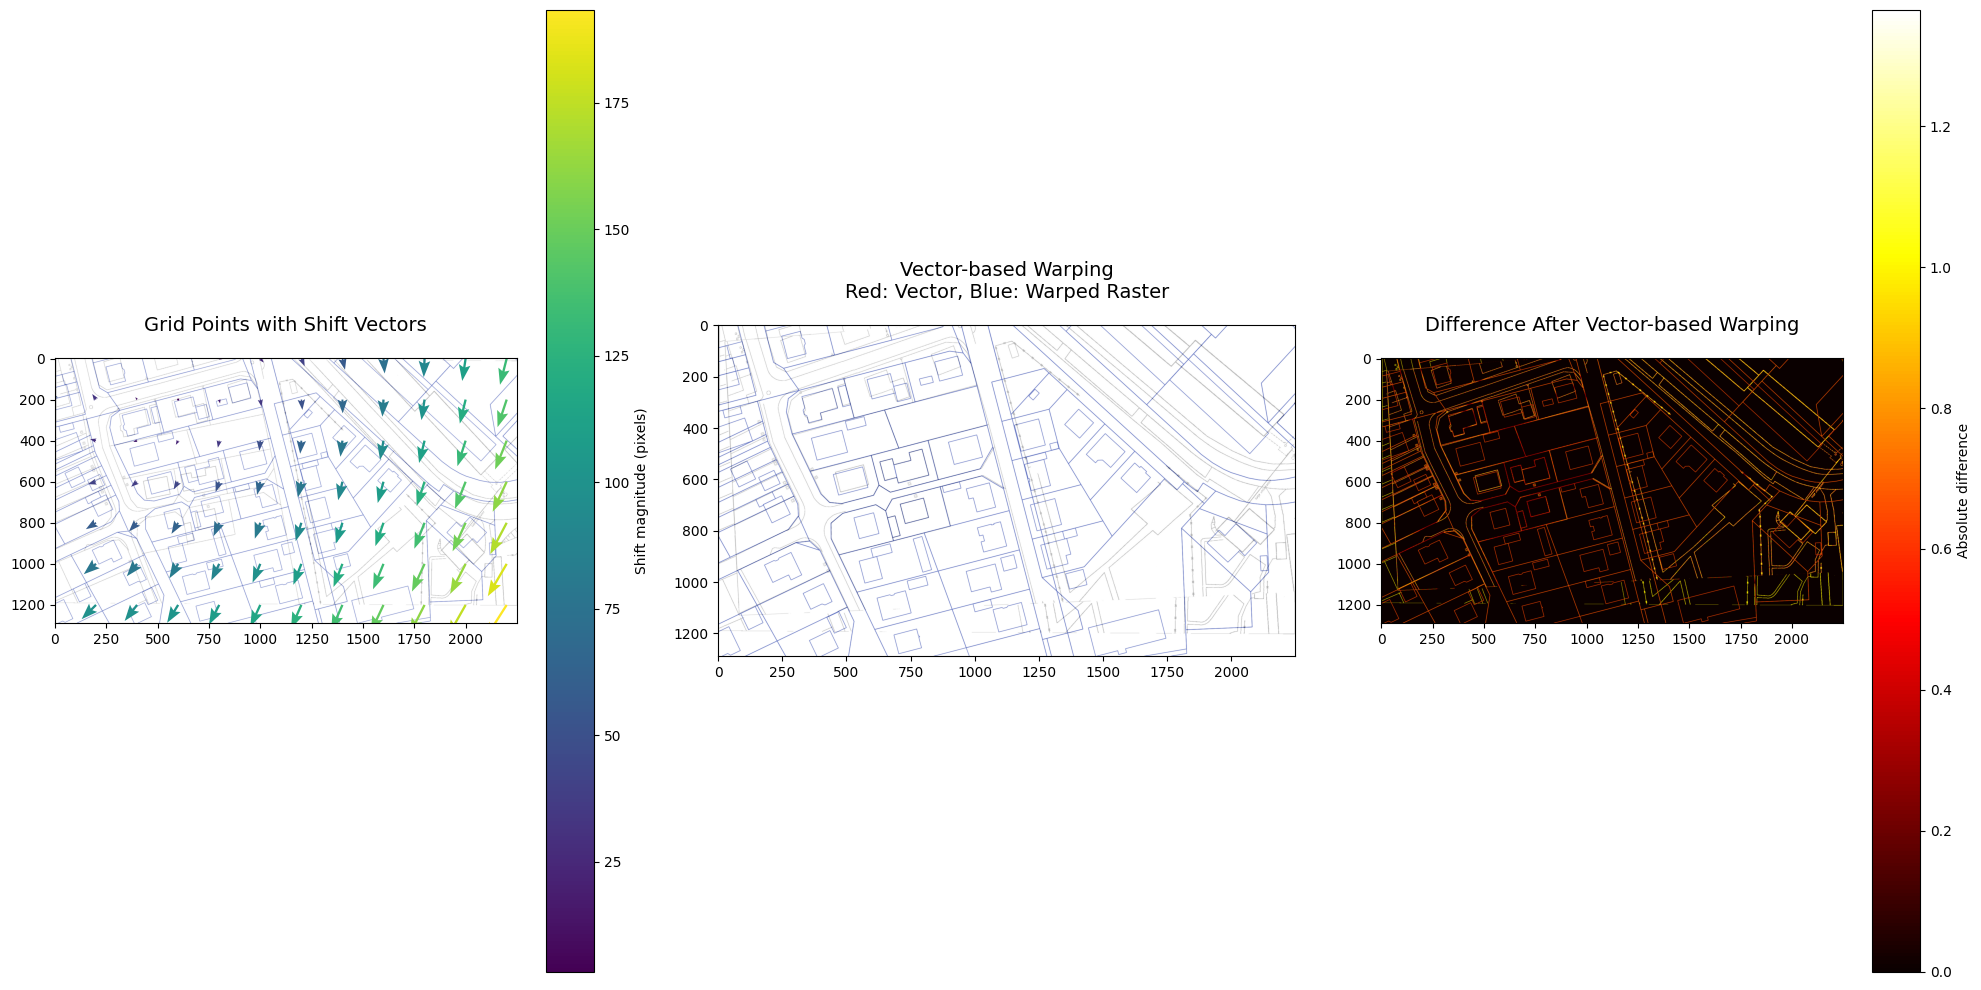

In [59]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.interpolate import griddata

def get_shifts_from_homography(H, image_shape, grid_spacing=50):
    """
    Extract shift vectors from homography matrix
    """
    height, width = image_shape[:2]

    # Create grid of points
    y, x = np.mgrid[0:height:grid_spacing, 0:width:grid_spacing]
    points = np.stack([x.ravel(), y.ravel()], axis=1)

    # Add homogeneous coordinate
    homogeneous_points = np.column_stack([points, np.ones(len(points))])

    # Transform points using homography
    transformed_points = H @ homogeneous_points.T
    transformed_points = transformed_points / transformed_points[2]
    transformed_points = transformed_points[:2].T

    # Calculate shifts
    shifts = transformed_points - points

    return points, shifts, transformed_points

# Get the grid points, shifts, and transformed points from homography
points, h_shifts, transformed_points = get_shifts_from_homography(H, image1_np.shape, grid_spacing=200)
h_magnitudes = np.sqrt(np.sum(h_shifts**2, axis=1))

# Create visualization
plt.figure(figsize=(20, 10))

# 1. Show grid and vectors
plt.subplot(131)
plt.imshow(image0_np, cmap='Reds', alpha=1.0)
plt.imshow(image1_np, cmap='Blues', alpha=0.3)

# Plot vectors (keeping the same visualization as before)
Q = plt.quiver(points[:, 0], points[:, 1],
              -h_shifts[:, 0], -h_shifts[:, 1],
              h_magnitudes,
              cmap='viridis',
              angles='xy',
              scale_units='xy',
              scale=1,
              width=0.005,
              headwidth=5,
              headlength=7,
              headaxislength=6,
              alpha=1.0)

plt.colorbar(Q, label='Shift magnitude (pixels)')
plt.title('Grid Points with Shift Vectors', fontsize=14, pad=20)

# 2. Create warped image using the vectors
plt.subplot(132)

# Create complete grid for remapping
h, w = image1_np.shape[:2]
grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1).astype(np.float32)

# Use points as destination and transformed points as source
map_x = griddata(transformed_points, points[:, 0], grid_points, method='cubic', fill_value=np.nan)
map_y = griddata(transformed_points, points[:, 1], grid_points, method='cubic', fill_value=np.nan)

# Reshape the interpolated points back to image shape
map_x = map_x.reshape(h, w).astype(np.float32)
map_y = map_y.reshape(h, w).astype(np.float32)

# Fill NaN values with original coordinates
mask_x = np.isnan(map_x)
mask_y = np.isnan(map_y)
map_x[mask_x] = grid_x[mask_x]
map_y[mask_y] = grid_y[mask_y]

# Apply the warping
warped_image = cv2.remap(image1_np, map_x, map_y, cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)

# Display warped result
plt.imshow(image0_np, cmap='Reds', alpha=1.0)
plt.imshow(warped_image, cmap='Blues', alpha=0.3)
plt.title('Vector-based Warping\nRed: Vector, Blue: Warped Raster', fontsize=14, pad=20)

# 3. Difference after warping
plt.subplot(133)
diff_after = np.abs(image0_np - warped_image).mean(axis=2)
plt.imshow(diff_after, cmap='hot')
plt.colorbar(label='Absolute difference')
plt.title('Difference After Vector-based Warping', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

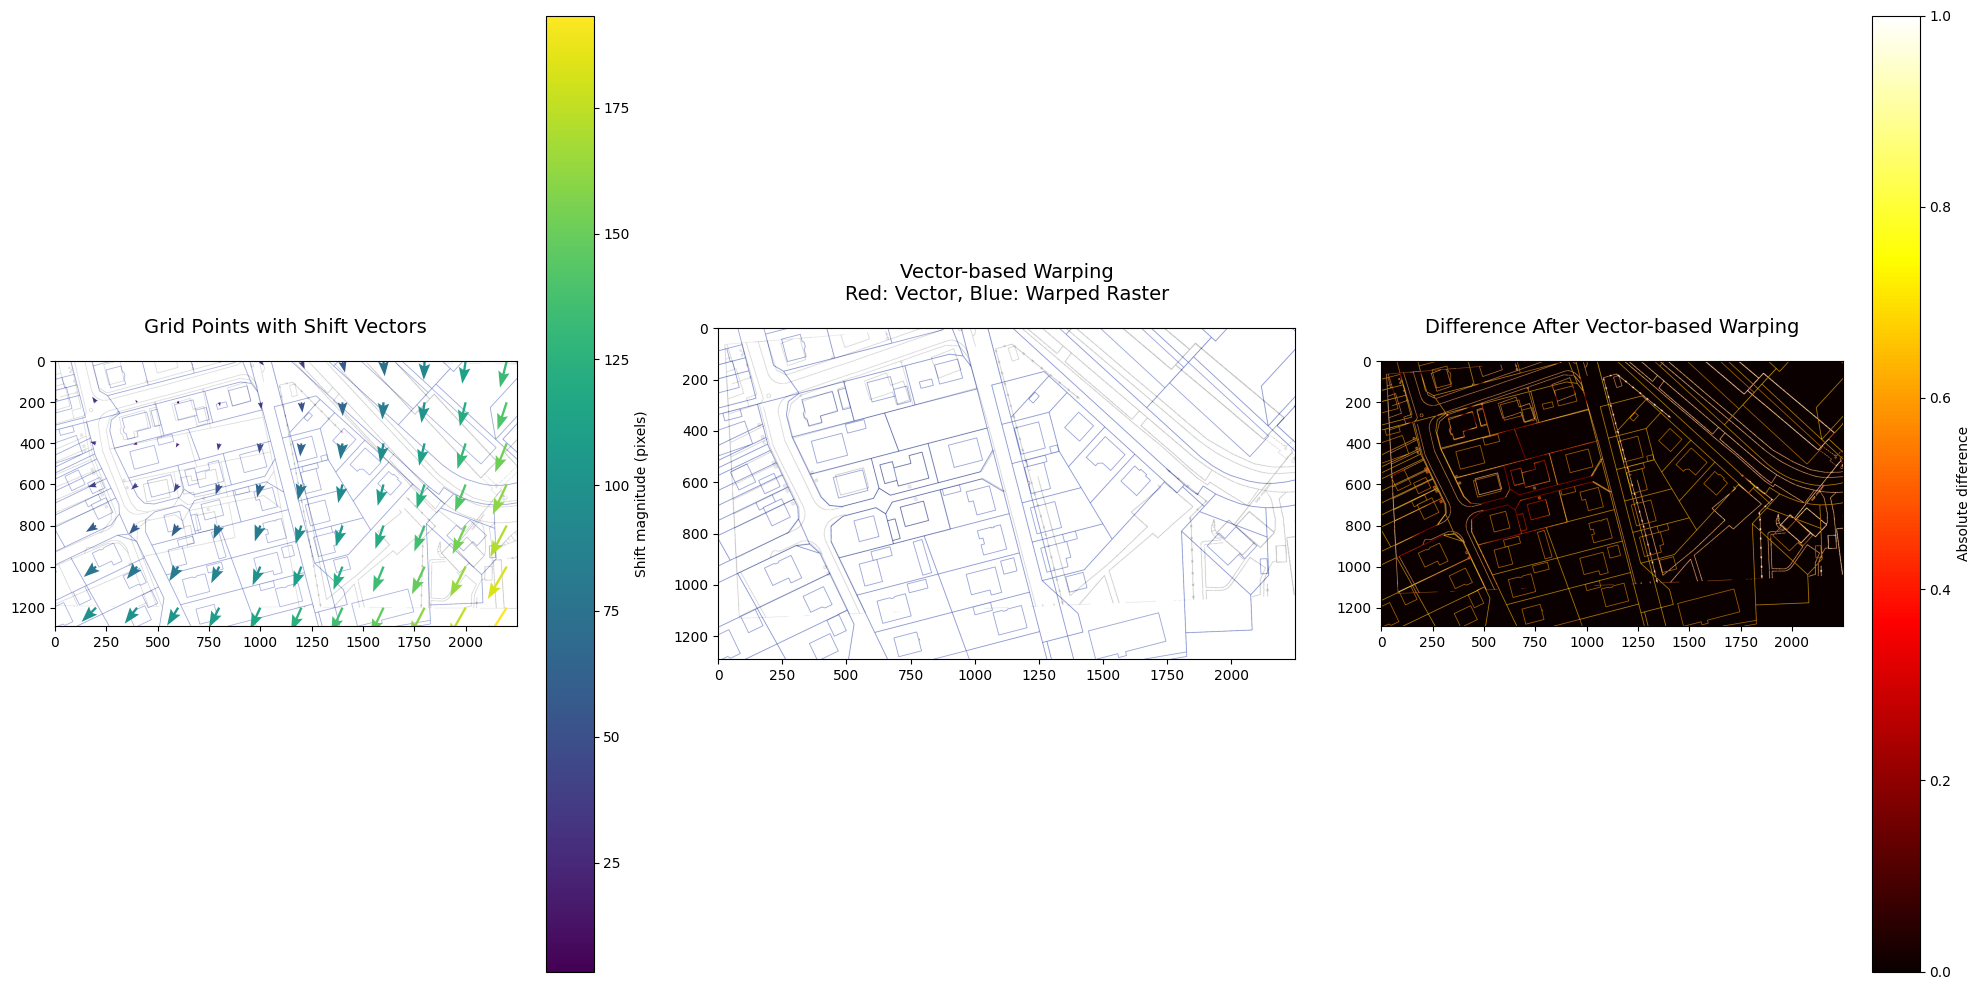

In [62]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator

def get_shifts_from_homography(H, image_shape, grid_spacing=200):
    """
    Extract shift vectors from homography matrix
    """
    height, width = image_shape[:2]

    # Create grid of points
    y, x = np.mgrid[0:height:grid_spacing, 0:width:grid_spacing]
    points = np.stack([x.ravel(), y.ravel()], axis=1)

    # Add homogeneous coordinate
    homogeneous_points = np.column_stack([points, np.ones(len(points))])

    # Transform points using homography
    transformed_points = H @ homogeneous_points.T
    transformed_points = transformed_points / transformed_points[2]
    transformed_points = transformed_points[:2].T

    # Calculate shifts
    shifts = transformed_points - points

    return points, shifts, transformed_points

# Get the grid points, shifts, and transformed points from homography
points, h_shifts, transformed_points = get_shifts_from_homography(H, image1_np.shape, grid_spacing=200)
h_magnitudes = np.sqrt(np.sum(h_shifts**2, axis=1))

# Create visualization
plt.figure(figsize=(20, 10))

# 1. Show grid and vectors
plt.subplot(131)
plt.imshow(image0_np, cmap='Reds', alpha=1.0)
plt.imshow(image1_np, cmap='Blues', alpha=0.3)

# Plot vectors
Q = plt.quiver(points[:, 0], points[:, 1],
              -h_shifts[:, 0], -h_shifts[:, 1],
              h_magnitudes,
              cmap='viridis',
              angles='xy',
              scale_units='xy',
              scale=1,
              width=0.005,
              headwidth=5,
              headlength=7,
              headaxislength=6,
              alpha=1.0)

plt.colorbar(Q, label='Shift magnitude (pixels)')
plt.title('Grid Points with Shift Vectors', fontsize=14, pad=20)

# 2. Create warped image using the vectors
plt.subplot(132)

# Create complete grid for remapping
h, w = image1_np.shape[:2]
grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)

# Create two-stage interpolation: linear for interior, nearest for edges
interp_x_linear = LinearNDInterpolator(transformed_points, points[:, 0], fill_value=-1)
interp_y_linear = LinearNDInterpolator(transformed_points, points[:, 1], fill_value=-1)

interp_x_nearest = NearestNDInterpolator(transformed_points, points[:, 0])
interp_y_nearest = NearestNDInterpolator(transformed_points, points[:, 1])

# Get both interpolations
map_x_linear = interp_x_linear(grid_points).reshape(h, w)
map_y_linear = interp_y_linear(grid_points).reshape(h, w)

map_x_nearest = interp_x_nearest(grid_points).reshape(h, w)
map_y_nearest = interp_y_nearest(grid_points).reshape(h, w)

# Combine interpolations: use linear where valid, nearest for fill values
map_x = np.where(map_x_linear >= 0, map_x_linear, map_x_nearest).astype(np.float32)
map_y = np.where(map_y_linear >= 0, map_y_linear, map_y_nearest).astype(np.float32)

# Apply the warping
warped_image = cv2.remap(image1_np, map_x, map_y, cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

# Display warped result
plt.imshow(image0_np, cmap='Reds', alpha=1.0)
plt.imshow(warped_image, cmap='Blues', alpha=0.3)
plt.title('Vector-based Warping\nRed: Vector, Blue: Warped Raster', fontsize=14, pad=20)

# 3. Difference after warping
plt.subplot(133)
diff_after = np.abs(image0_np - warped_image).mean(axis=2)
plt.imshow(diff_after, cmap='hot')
plt.colorbar(label='Absolute difference')
plt.title('Difference After Vector-based Warping', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

In [21]:
def get_homography_shifts_array(H, image_shape, pixel_size, grid_spacing=80):
    """
    Extract shift vectors from homography matrix and convert to meters
    Returns:
    - grid_points: Nx2 array of grid point coordinates
    - shifts_meters: Nx2 array of shifts in meters [x_shift, y_shift]
    - magnitudes_meters: N array of shift magnitudes in meters
    """
    # Create grid of points
    height, width = image_shape[:2]
    y, x = np.mgrid[0:height:grid_spacing, 0:width:grid_spacing]
    points = np.stack([x.ravel(), y.ravel()], axis=1)

    # Add homogeneous coordinate
    homogeneous_points = np.column_stack([points, np.ones(len(points))])

    # Transform points using homography
    transformed_points = H @ homogeneous_points.T
    transformed_points = transformed_points / transformed_points[2]  # Normalize homogeneous coordinates
    transformed_points = transformed_points[:2].T

    # Calculate shifts in pixels
    shifts_px = transformed_points - points

    # Convert to meters
    shifts_meters = shifts_px * pixel_size
    magnitudes_meters = np.sqrt(np.sum(shifts_meters**2, axis=1))

    return points, shifts_meters, magnitudes_meters

# Get the shifts array
grid_points, shifts_meters, magnitudes_meters = get_homography_shifts_array(H, image1_np.shape, pixel_size)

# Print some statistics
print("Homography shifts in meters:")
print(f"Shape of shifts array: {shifts_meters.shape}")
print(f"Average magnitude: {np.mean(magnitudes_meters):.3f} m")
print(f"Max magnitude: {np.max(magnitudes_meters):.3f} m")
print(f"Min magnitude: {np.min(magnitudes_meters):.3f} m")

# Example of how to access the data:
print("\nFirst 5 shifts:")
for i in range(5):
    x, y = grid_points[i]
    dx, dy = shifts_meters[i]
    mag = magnitudes_meters[i]
    print(f"Point ({x:.1f}, {y:.1f}): shift = [{dx:.3f}m, {dy:.3f}m], magnitude = {mag:.3f}m")

NameError: name 'pixel_size' is not defined

In [18]:
def get_homography_shifts_array(H, image_shape, pixel_size, grid_spacing=100):
    """
    Extract shift vectors from homography matrix and convert to meters
    """
    height, width = image_shape[:2]
    y, x = np.mgrid[0:height:grid_spacing, 0:width:grid_spacing]
    points = np.stack([x.ravel(), y.ravel()], axis=1)

    homogeneous_points = np.column_stack([points, np.ones(len(points))])
    transformed_points = H @ homogeneous_points.T
    transformed_points = transformed_points / transformed_points[2]
    transformed_points = transformed_points[:2].T

    shifts_px = transformed_points - points
    shifts_meters = shifts_px * pixel_size
    magnitudes_meters = np.sqrt(np.sum(shifts_meters**2, axis=1))

    return points, shifts_meters, magnitudes_meters

# Set grid spacing
GRID_SPACING = 50

# Get the shifts array
grid_points, shifts_meters, magnitudes_meters = get_homography_shifts_array(H, image1_np.shape, pixel_size, GRID_SPACING)

# Create visualization
plt.figure(figsize=(15, 10))

# Plot background image
plt.imshow(image0_np, cmap='gray', alpha=0.3)

# Plot shifts with arrows - with inverted directions
Q = plt.quiver(grid_points[:, 0], grid_points[:, 1],
              -shifts_meters[:, 0], -shifts_meters[:, 1],  # Negative signs to invert direction
              magnitudes_meters,
              cmap='viridis',
              angles='xy',
              scale_units='xy',
              scale=0.1,
              width=0.005,
              headwidth=8,
              headlength=10,
              headaxislength=8,
              minshaft=2,
              minlength=0.1)

# Add colorbar
cbar = plt.colorbar(Q, label='Shift magnitude (meters)')
cbar.ax.tick_params(labelsize=10)

# Add title and labels
plt.title(f'Homography-based Shifts (meters)\nGrid spacing: {GRID_SPACING} pixels', fontsize=14, pad=20)
plt.xlabel('X (pixels)', fontsize=12)
plt.ylabel('Y (pixels)', fontsize=12)

# Add a reference arrow for scale
ref_magnitude = 2.0  # meters
plt.quiverkey(Q, 0.9, 0.95, ref_magnitude, f'{ref_magnitude}m',
              labelpos='E',
              coordinates='figure',
              color='black',
              labelcolor='black',
              fontproperties={'size': 10})

plt.tight_layout()
plt.show()

# Print statistics
print("\nHomography shifts statistics (meters):")
print(f"Grid spacing: {GRID_SPACING} pixels")
print(f"Number of grid points: {len(grid_points)}")
print(f"Average magnitude: {np.mean(magnitudes_meters):.3f} m")
print(f"Median magnitude: {np.median(magnitudes_meters):.3f} m")
print(f"Max magnitude: {np.max(magnitudes_meters):.3f} m")
print(f"Min magnitude: {np.min(magnitudes_meters):.3f} m")

NameError: name 'pixel_size' is not defined